In [1]:
# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

# Geospatial Analysis
import geopandas as gpd
import folium
from h3 import h3

# General-purpose
import numpy as np
import scipy

#My-SQL
import mysql.connector
from mysql.connector import Error

## Connect to Database with Gett Data

---

In [2]:
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='gett_taxi_database',
                                         user='root',
                                         password='admin')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)
# finally:
#     if connection.is_connected():
#         cursor.close()
#         connection.close()
#         print("MySQL connection is closed")

Connected to MySQL Server version  8.0.34
You're connected to database:  ('gett_taxi_database',)


### A Query giving us access to the data in the data_orders table.

---

In [3]:
 #The Query
sql_select_Query = "select * from data_orders"
cursor = connection.cursor()

# Execute the query
cursor.execute(sql_select_Query)

# Fetch the data
records = cursor.fetchall()

# Column names
column_names = [i[0] for i in cursor.description]

# Put the data into a pandas DataFrame
df = pd.DataFrame(records, columns=column_names)

# Don't forget to close the cursor and connection
cursor.close()
connection.close()

# Display the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_gk                       10716 non-null  int64  
 1   order_time                     10716 non-null  object 
 2   origin_longitude               10716 non-null  object 
 3   origin_latitude                10716 non-null  object 
 4   minutes_order_eta              2814 non-null   float64
 5   order_status_key               10716 non-null  object 
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 669.9+ KB


#### Updating Column Data Types

In [10]:
#First thing we want to do is get our Data types correct for our use case:
df["order_status_key"] = df["order_status_key"].astype("category")
df["is_driver_assigned_key"] = df["is_driver_assigned_key"].astype("category")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   order_gk                       10716 non-null  int64   
 1   order_time                     10716 non-null  object  
 2   origin_longitude               10716 non-null  object  
 3   origin_latitude                10716 non-null  object  
 4   minutes_order_eta              2814 non-null   float64 
 5   order_status_key               10716 non-null  category
 6   is_driver_assigned_key         10716 non-null  category
 7   cancellations_time_in_seconds  7307 non-null   float64 
dtypes: category(2), float64(2), int64(1), object(3)
memory usage: 523.6+ KB


1. Build up distribution of orders according to reasons for failure: 
cancellations before and after driver assignment, 
and reasons for order rejection. 

    Analyse the resulting plot. Which category has the highest number of orders?

---

#### Bar plot comparing Order Status Key

In [24]:
#The index represents the unique cancellation codes in the data and the values are the count.
#df['order_status_key'].value_counts()


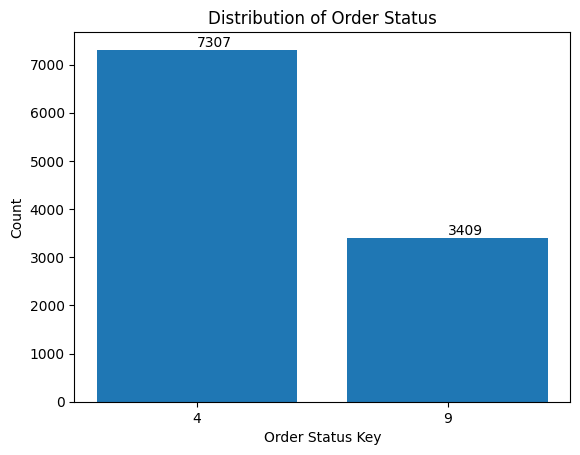

In [13]:
# Get the value counts
value_counts = df['order_status_key'].value_counts()

# Get categories and values
categories = value_counts.index
values = value_counts.values

# Create the bar plot
bars = plt.bar(categories, values)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xlabel('Order Status Key')
plt.ylabel('Count')
plt.title('Distribution of Order Status')

plt.show()

---
---

#### Bar plot comparing Driver assignment

In [23]:
#df['is_driver_assigned_key'].value_counts()

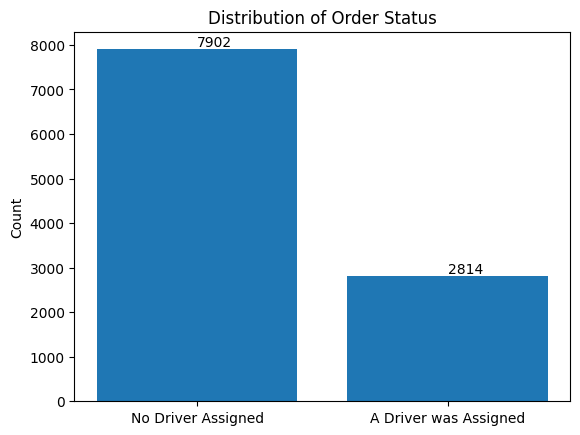

In [22]:
# Get the value counts
value_counts = df['is_driver_assigned_key'].value_counts()

# Get categories and values
categories = value_counts.index
values = value_counts.values

# Create the bar plot
bars = plt.bar(categories, values)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xticks(ticks=[0,1], labels=["No Driver Assigned","A Driver was Assigned"])
plt.xlabel('')
plt.ylabel('Count')
plt.title('Order Cancellation by Driver Assignment')

plt.show()

## Important details to note before continuing:

---

-An order will only have a cancellation time recorded if the *client* cancels the order.

-If the system cancels an order than there will be no recored cancellation time.

-Every row in this table is a cancelled order so we need to divide them based on the reason for cancellation

1. Build up distribution of orders according to reasons for failure: 
cancellations before and after driver assignment, 
and reasons for order rejection. 

    Analyse the resulting plot. Which category has the highest number of orders?

In [29]:
# Don't forget to close the cursor and connection
cursor.close()
connection.close()